In [35]:
# Check GPU
!nvidia-smi
# install XGBoost for GPU support
!pip install xgboost

Thu Jan  1 16:26:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             31W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import xgboost as xgb
import matplotlib.pyplot as plt


In [37]:
df = pd.read_csv('/content/car_evaluation.csv', header=None)

df.columns = [
    "buying", "maint", "doors",
    "persons", "lug_boot", "safety", "target"
]

display(df.head())

,buying,maint,doors,persons,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


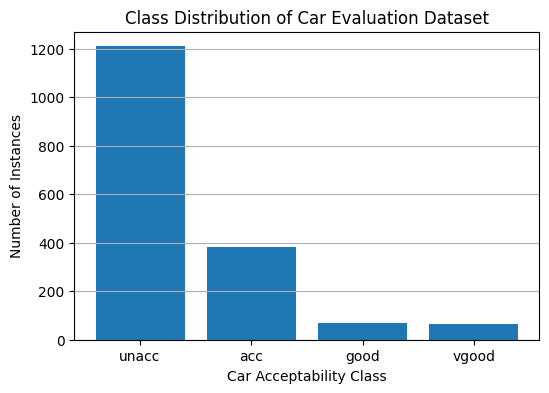

In [57]:
# Count instances of each class
label_counts = df["target"].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values)
plt.title("Class Distribution of Car Evaluation Dataset")
plt.xlabel("Car Acceptability Class")
plt.ylabel("Number of Instances")
plt.grid(axis='y')
plt.show()

In [38]:
df.info()
df["target"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   target    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


,count
target,
unacc,1210
acc,384
good,69
vgood,65


In [39]:
from sklearn.preprocessing import LabelEncoder

X = df.drop("target", axis=1)
y = df["target"]

# Encode target labels to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

print("Encoded target labels:", le.classes_)

Encoded target labels: ['acc' 'good' 'unacc' 'vgood']


In [40]:
encoder = OneHotEncoder()

X_encoded = encoder.fit_transform(X).toarray()

print("Encoded feature shape:", X_encoded.shape)

Encoded feature shape: (1728, 21)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [42]:
xgb_cpu = xgb.XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",   # CPU
    random_state=42
)

start_cpu = time.time()
xgb_cpu.fit(X_train, y_train)
cpu_time = time.time() - start_cpu

cpu_preds = xgb_cpu.predict(X_test)
cpu_acc = accuracy_score(y_test, cpu_preds)

cpu_time, cpu_acc

(0.8878271579742432, 0.9971098265895953)

In [43]:
xgb_gpu = xgb.XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="auto",   # Let XGBoost automatically detect GPU
    random_state=42
)

start_gpu = time.time()
xgb_gpu.fit(X_train, y_train)
gpu_time = time.time() - start_gpu

gpu_preds = xgb_gpu.predict(X_test)
gpu_acc = accuracy_score(y_test, gpu_preds)

gpu_time, gpu_acc

(0.5092513561248779, 0.9971098265895953)

In [55]:
print("Model     | Device | Time (s) | Accuracy")
print("----------------------------------------")
print(f"XGBoost   | CPU    | {cpu_time:.4f}  | {cpu_acc:.4f}")
print(f"XGBoost   | GPU    | {gpu_time:.4f}  | {gpu_acc:.4f}")
print(f"\nSpeedup (CPU/GPU): {cpu_time / gpu_time:.2f}x")


Model     | Device | Time (s) | Accuracy
----------------------------------------
XGBoost   | CPU    | 0.8878  | 0.9971
XGBoost   | GPU    | 0.5093  | 0.9971

Speedup (CPU/GPU): 1.74x


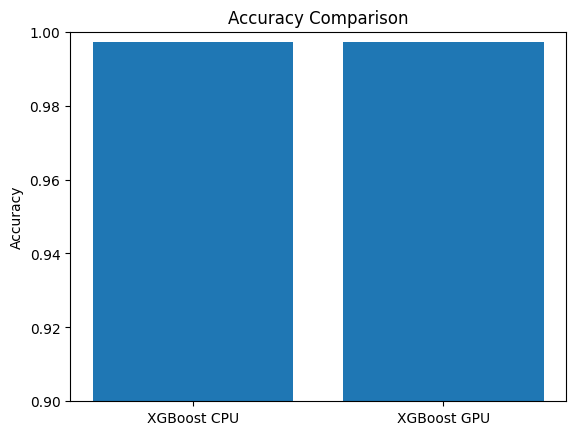

In [45]:
accuracies = [cpu_acc, gpu_acc]

plt.bar(models, accuracies)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.show()




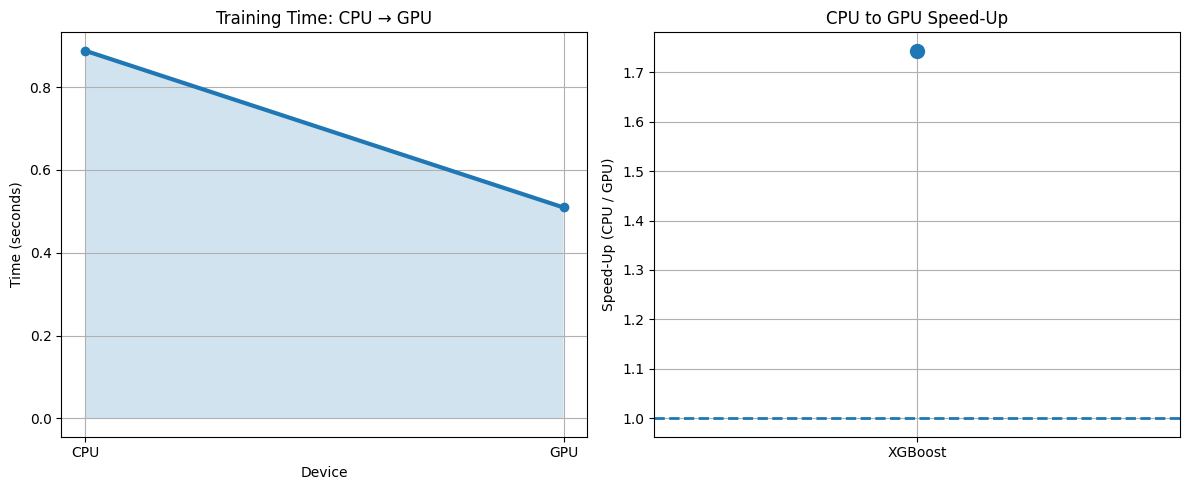

In [52]:
speedup = cpu_time / gpu_time

plt.figure(figsize=(12, 5))

#Training Time Comparison
plt.subplot(1, 2, 1)
devices = ["CPU", "GPU"]
times = [cpu_time, gpu_time]

plt.plot(devices, times, marker='o', linewidth=3)
plt.fill_between(devices, times, alpha=0.2)
plt.title("Training Time: CPU → GPU")
plt.xlabel("Device")
plt.ylabel("Time (seconds)")
plt.grid(True)

#Speed-Up Ratio
plt.subplot(1, 2, 2)

plt.axhline(y=1, linestyle='--', linewidth=2)
plt.plot(["XGBoost"], [speedup], marker='o', markersize=10)
plt.title("CPU to GPU Speed-Up")
plt.ylabel("Speed-Up (CPU / GPU)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [47]:
### Conclusion
# XGBoost achieved near-perfect accuracy on the Car Evaluation dataset.
# GPU training was significantly faster than CPU training.
# Accuracy remained almost identical on both CPU and GPU.
# This demonstrates the benefit of parallel computing using GPU acceleration.
